# **UCI STUDENT DATA QUERIES**

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.models import DiscreteBayesianNetwork 
from pgmpy.estimators import MaximumLikelihoodEstimator
import networkx as nx
from pgmpy.inference import VariableElimination
import logging

The dataset can be found at : [LINK](https://archive.ics.uci.edu/dataset/320/student%2Bperformance)\
We make use of the student-mat.csv file, details of the same will be visible in the .txt file in the downloaded zip.

In [47]:
D = pd.read_csv('student-mat.csv', sep=';')
D.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


Custom Bayesian Network created using the relevant features as follows :

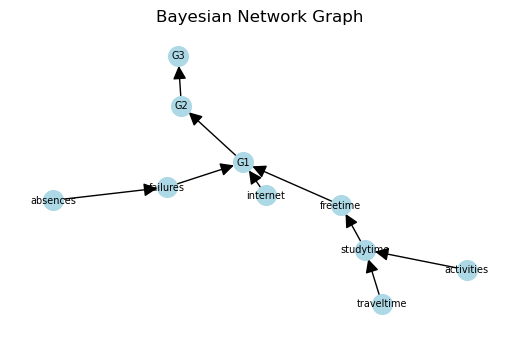

In [ ]:

edges = [
    ('activities', 'studytime'),
    ('studytime', 'freetime'),
    ('traveltime', 'studytime'),
    ('internet', 'G1'),
    ('freetime', 'G1'),
    ('absences', 'failures'),
    ('failures', 'G1'),
    ('G1', 'G2'),
    ('G2', 'G3')
]

G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(5, 3))
pos = nx.spring_layout(G, seed=4)                                                                           # calculates positions of nodes using Fruchterman-Reingold algorithm
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=200, font_size=7, arrowsize=20)         
plt.title("Bayesian Network Graph")
plt.show()


In [49]:
relevant_features = ['activities', 'traveltime', 'studytime', 'freetime', 'internet', 'absences', 'failures', 'G1', 'G2', 'G3']
D = D[relevant_features]

# label encoding the non float values 
le = LabelEncoder()
D['internet'] = le.fit_transform(D['internet'])     
D['activities'] = le.fit_transform(D['activities'])

D.head()

,activities,traveltime,studytime,freetime,internet,absences,failures,G1,G2,G3
0,0,2,2,3,0,6,0,5,6,6
1,0,1,2,3,1,4,0,5,5,6
2,0,1,2,3,1,10,3,7,8,10
3,1,1,3,2,1,2,0,15,14,15
4,0,1,2,3,0,4,0,6,10,10


The data values need to be discretized into bins. This will ensure that the model doesnt try to learn the individual values that are obtained with each evidence vector, but instead gets a general gist of the same. 

In [ ]:
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')      # uniform strat sets sizes of all bins to be equal, encode = ordinal/onehot, onehot sets to 0 / 1 whereas ordinal sets the values to be integers
D = pd.DataFrame(discretizer.fit_transform(D), columns=relevant_features)
D = D.astype(int)                                                                   # convert from float to int

In [ ]:
model = DiscreteBayesianNetwork ([
    ('activities', 'studytime'),
    ('traveltime', 'studytime'),
    ('studytime', 'freetime'),
    ('internet', 'G1'),
    ('freetime', 'G1'),
    ('absences', 'failures'),
    ('failures', 'G1'),
    ('G1', 'G2'),
    ('G2', 'G3')
])

logging.getLogger("pgmpy").setLevel(logging.WARNING)    # Prevents info log data

model.fit(D, estimator=MaximumLikelihoodEstimator);

Using the Variable Elimination method of solving bayesian networks to get results of the query.

In [ ]:
infer = VariableElimination(model)                          # defining tge inference object 

evidence = {'studytime': 2, 'failures': 0, 'absences': 1, 'G1': 2, 'G2': 2}     # E vector

result = infer.query(variables=['G3'], evidence=evidence)   # Query based on the given evidence to find the predicted bin of G3

print(result)

+-------+-----------+
| G3    |   phi(G3) |
+=======+===========+
| G3(0) |    0.0000 |
+-------+-----------+
| G3(1) |    0.2283 |
+-------+-----------+
| G3(2) |    0.7717 |
+-------+-----------+


### Maths :

Let $E$ be the Evidence we currently have. $F_r$ be the set of Relevant Features. $F$ be the set of all Features.

We want, 

$$
P(G_3 \mid E) = \frac{P(G_3, E)}{\Sigma_g P(G_3 = g, E)} = \alpha \cdot P(G_3, E)
$$

Where, 

$$
P(G_3, E) = \Sigma_{(F_r - E)}  P(F)
$$

So, As $F_r = \{$ Activities, Traveltime, Internet, Freetime $\}$ \
\
and\
\
a ∈ Activities, t ∈ Traveltime, i ∈ Internet, f ∈ Freetime :

$$
P(G_3 \mid E) = \alpha \cdot \Sigma_{a, t, i, f} [P(a) \cdot P(t) \cdot P(ab) \cdot P(i) \cdot P(s \mid a, t) \cdot P(f \mid s) \cdot P(G_1 \mid f, i, fa) \cdot P(G_2 \mid G1) \cdot P(G_3 \mid G_2) \cdot P(fa \mid ab)]
$$

After this, the maths is identical to the heart disease prediction notebook